In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('..') # add the root folder to the path

from diffusion_model import Scheduler, Forwarder, Backwarder, Model, get_mnist_dataset, device

import torch
import matplotlib.pyplot as plt
import matplotlib
from einops import rearrange

FIG_SIZE = 4
matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

print(f"Using device: {device}")

Using device: cuda


# Plot helper functions

In [3]:
def many_imshow(xs, y_title=None, title=None):
    fig, axes = plt.subplots(1, len(xs), figsize=(FIG_SIZE*len(xs), FIG_SIZE))
    if title is not None:
        fig.suptitle(title)
    if y_title is not None:
        axes[0].set_ylabel(y_title)
    for i, ax in enumerate(axes):
        progress = i / (len(xs)-1)
        ax.imshow(xs[i].cpu(), cmap='gray')
        ax.set_title(f"t={progress*100:.0f}%")
    plt.show()

# Datasets

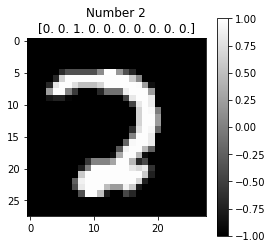

In [4]:
N_SAMPLES = 1000

X, y = get_mnist_dataset()
y_hot = torch.nn.functional.one_hot(y, 10).float().to(device)

idx = torch.randint(0, len(X), (1,))[0]
plt.imshow(X[idx].cpu(), cmap="gray")
plt.title(f"Number {y[idx]}\n{y_hot[idx].cpu().numpy()}")
plt.colorbar();

# Diffusion model

## Scheduler

beta: min=0.0, max=0.9990000128746033


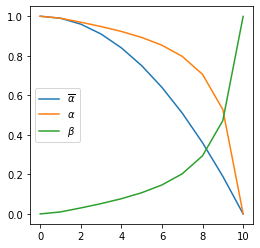

In [41]:
T = 10

sch = Scheduler(n_steps=T, schedule_type="linear-reparam")

plt.plot(sch.alphas_bar.cpu(), label="$\overline{\\alpha}$")
plt.plot(sch.alphas.cpu(), label="$\\alpha$")
plt.plot(sch.betas.cpu(), label="$\\beta$")
plt.legend()

print(f"beta: min={sch.betas.min().item()}, max={sch.betas.max().item()}")

## Forward

Forwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 6251.86it/s]


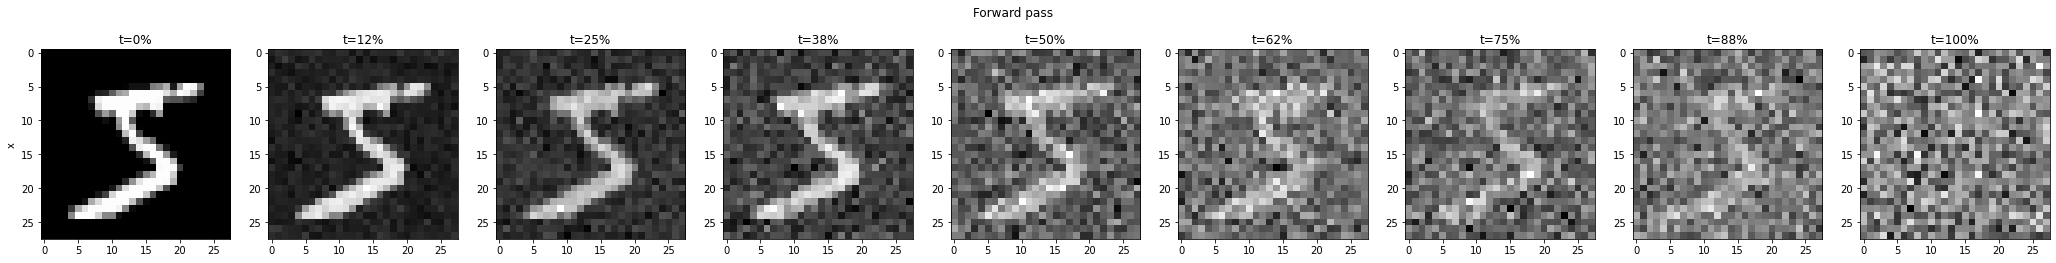

Forwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 4062.06it/s]


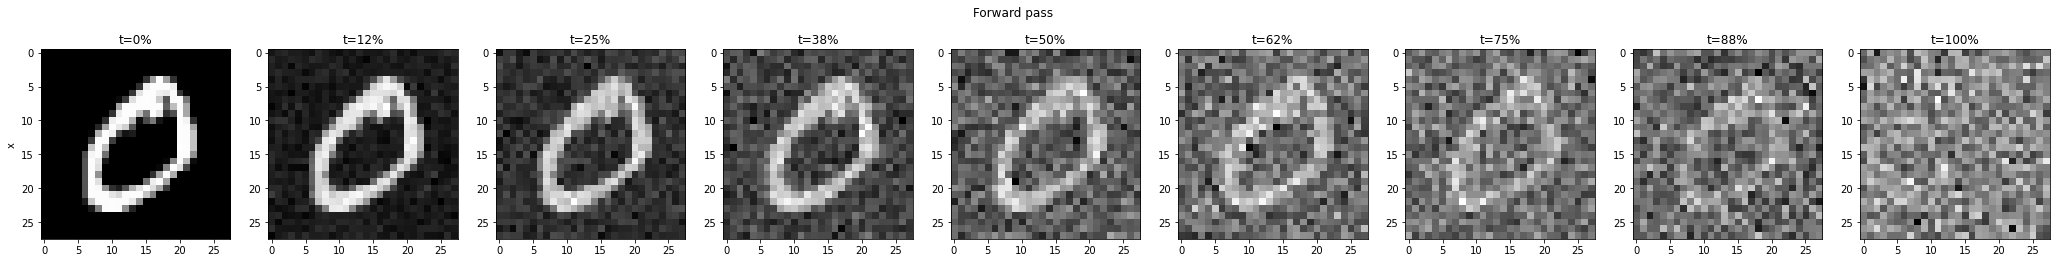

Forwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 4465.72it/s]


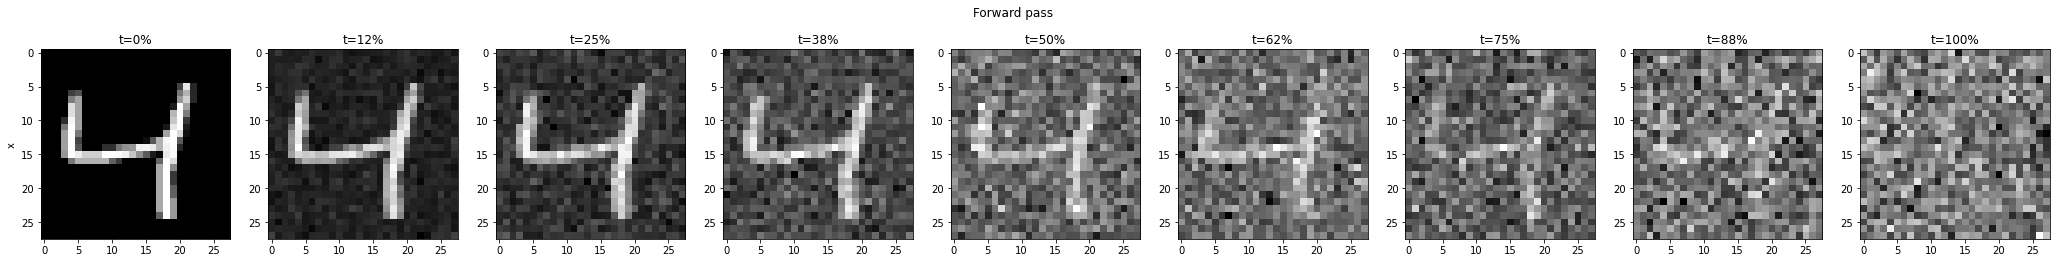

In [46]:
fwd = Forwarder(scheduler=sch)

for x in X[:3]:
    x = x.to(device)
    x_by_t = fwd.forward_loop(x)
    many_imshow(x_by_t, y_title="x", title="Forward pass")

## Backward

In [75]:
model = Model(scheduler=sch, forwarder=fwd)
bkw = Backwarder(scheduler=sch, model=model, sigma="beta")

In [76]:
def plot_backward():
  idx = torch.randint(0, len(X), (1,))[0]
  rand_y = rearrange(y_hot[idx], "d -> 1 d")
  xt = bkw.backward_loop(rand_y, shape=(1, *X.shape[1:]))
  xt = rearrange(xt, "t 1 h w -> t h w")
  many_imshow(xt, y_title="x", title=f"Backward pass for number {y[idx]}")

def logger(epoch, losses):
  print(f"Epoch {epoch}: loss={sum(losses)/len(losses)}")
  plot_backward()

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 21.63it/s]


Epoch 0: loss=0.4740387085130659


Backwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 350.15it/s]


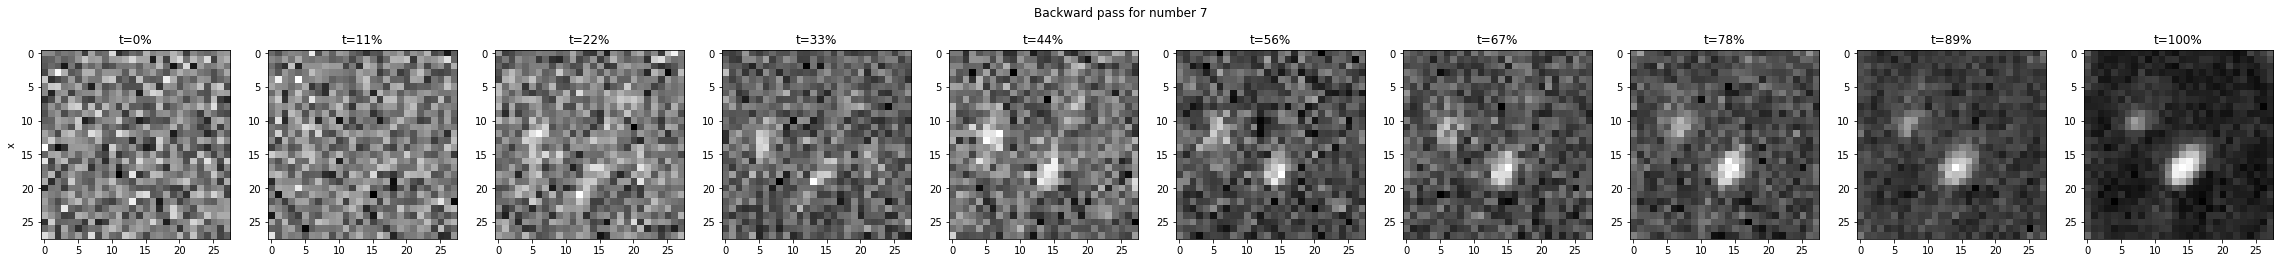

Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 21.39it/s]


Epoch 10: loss=0.30678852988501726


Backwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 348.37it/s]


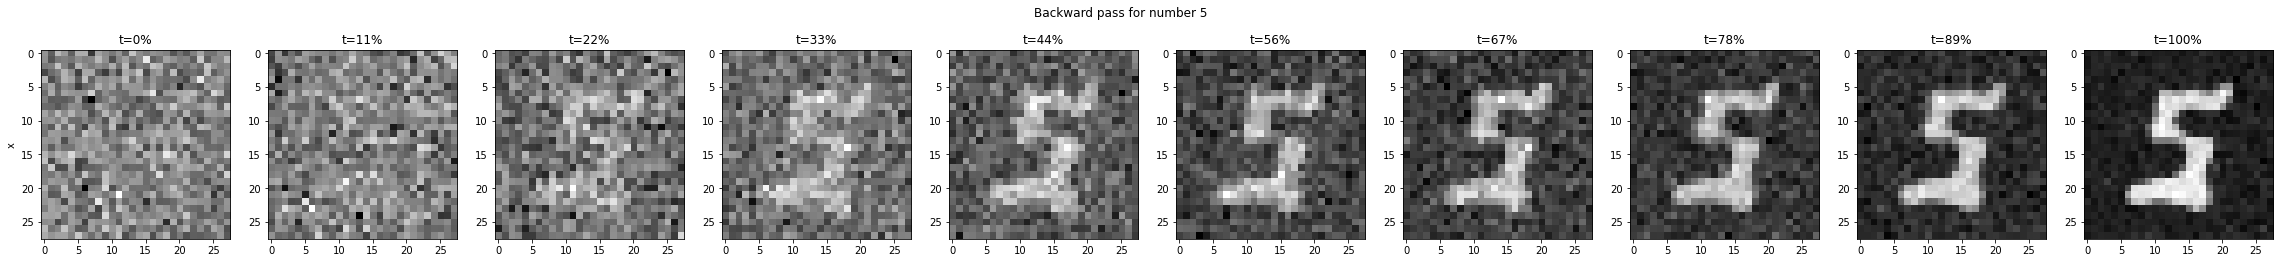

Epoch 12:   7%|█████▏                                                                      | 4/59 [00:00<00:02, 21.94it/s]


KeyboardInterrupt: 

In [77]:
dataset = torch.utils.data.TensorDataset(X, y_hot)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024)
model.fit(dataloader, logger=logger, n_epochs=100)

Backwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 250.35it/s]


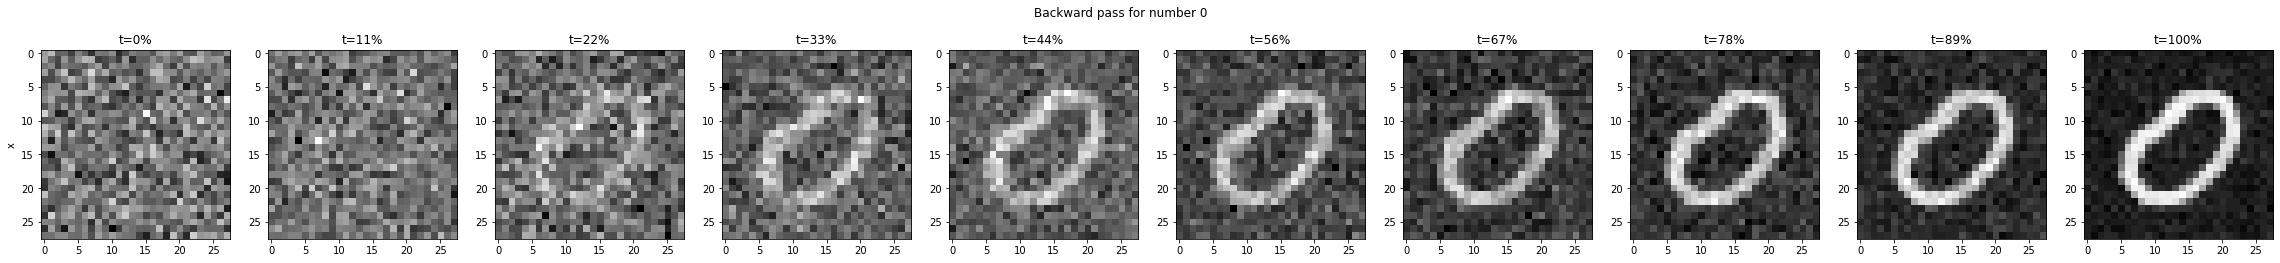

In [78]:
plot_backward()

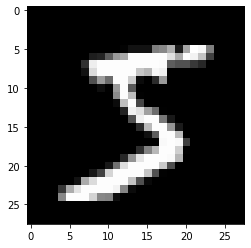

In [50]:
x = X[0]
plt.imshow(x.cpu(), cmap="gray")

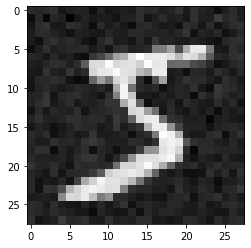

In [53]:
xt, noise = fwd.forward_one(x, torch.Tensor([1]).long())
plt.imshow(xt.cpu(), cmap="gray")

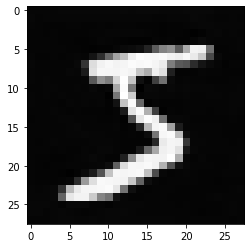

In [54]:
x_pred = model.forward_one(xt, torch.Tensor([1]).to(device), y_hot[0])
plt.imshow(x_pred.detach().cpu(), cmap="gray")

## Evaluation

In [83]:
labels = (torch.arange(0, 100) % 10).to(device)
labels = y_hot[labels]

with torch.no_grad():
  xst = bkw.backward_loop(labels, shape=(len(labels), 28, 28))

xs = rearrange(xst[-1], "(b n) h w -> n b h w", n=10)
for i, row in enumerate(xs):
  many_imshow(row, y_title=f"Number {i}")

Backwarding: 100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 316.88it/s]


EinopsError:  Error while processing rearrange-reduction pattern "(n n) h w -> n 10 h w".
 Input tensor shape: torch.Size([100, 28, 28]). Additional info: {'n': 10}.
 Indexing expression contains duplicate dimension "n"

In [ ]:
_, axes = plt.subplots(10, 1, figsize=(1*FIG_SIZE, 10*FIG_SIZE))

for i in range(10):
  selected = dataset[labels == i]
  x = sum(selected)/len(selected)
  axes[i].imshow(x.cpu(), cmap="gray")
  axes[i].set_title(f"mean of number {i}")